In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/Users/lexie_chen/Desktop/project/Loan_status_2007-2020Q3.gzip"
df = pd.read_csv(file_path, index_col=0)
df.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


We want to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment.

Risk Analytics (understanding the types of variables and their significance).

In [3]:
data = df

## Exploratory Data Analysis
**1. Missing Values**

In [4]:
missing_data = pd.DataFrame(df.isna().sum()).reset_index().rename(columns={'index': 'Column', 0: 'mis_count'}).query('mis_count > 0').assign(Missing_Percentage=lambda x: x['mis_count'] / df.shape[0] * 100).sort_values('mis_count', ascending=False).reset_index(drop=True)
missing_data

,Column,mis_count,Missing_Percentage
0,hardship_loan_status,2782082,95.097886
1,hardship_reason,2781861,95.090332
2,hardship_status,2781858,95.090229
3,hardship_dpd,2781856,95.090161
4,payment_plan_start_date,2781855,95.090127
...,...,...,...
135,last_pymnt_amnt,1,0.000034
136,last_fico_range_high,1,0.000034
137,last_fico_range_low,1,0.000034
138,policy_code,1,0.000034


In [5]:
# 删除缺失值超过 10% 的列
threshold_delete = 10
columns_to_delete = missing_data[missing_data['Missing_Percentage'] > threshold_delete]['Column']
df = df.drop(columns=columns_to_delete, errors='ignore')

# 删除缺失值在 0%-1% 的列对应的行
threshold_drop_lower = 0
threshold_drop_upper = 1
columns_to_drop_rows = missing_data[
    (missing_data['Missing_Percentage'] > threshold_drop_lower) & 
    (missing_data['Missing_Percentage'] <= threshold_drop_upper)
]['Column']

for col in columns_to_drop_rows:
    df = df.dropna(subset=[col])

# 填补缺失值在 1%-10% 的列
threshold_fill_lower = 1
threshold_fill_upper = 10
columns_to_fill = missing_data[
    (missing_data['Missing_Percentage'] > threshold_fill_lower) & 
    (missing_data['Missing_Percentage'] <= threshold_fill_upper)
]['Column']

for col in columns_to_fill:
    if df[col].dtype == 'object':  # 分类数据用众数填充
        df[col] = df[col].fillna(df[col].mode()[0])
    else:  # 数值型数据用中位数填充
        df[col] = df[col].fillna(df[col].median())

# 打印结果
print("Deleted columns (missing >10%):", columns_to_delete.tolist())
print("Deleted rows (missing 0%-1%):", columns_to_drop_rows.tolist())
print("Filled columns (missing 1%-10%):", columns_to_fill.tolist())


Deleted columns (missing >10%): ['hardship_loan_status', 'hardship_reason', 'hardship_status', 'hardship_dpd', 'payment_plan_start_date', 'hardship_start_date', 'hardship_end_date', 'deferral_term', 'hardship_length', 'hardship_type', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_amount', 'hardship_last_payment_amount', 'sec_app_revol_util', 'verification_status_joint', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_num_rev_accts', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_mort_acc', 'sec_app_chargeoff_within_12_mths', 'sec_app_fico_range_high', 'dti_joint', 'annual_inc_joint', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'mths_since_last_delinq', 'il_util', 'mths_since_rcnt_il', 'all_util', 'inq_last_12m', 'total_cu_tl', 'open_acc_6m', 'max_bal_b

**2. EDA**

In [6]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,...,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06,2.890161e+06
mean,1.536300e+04,1.535896e+04,1.534745e+04,4.524505e+02,8.009190e+04,1.930428e+01,2.890396e-01,7.005519e+02,7.045521e+02,5.533418e-01,...,7.481486e-02,2.070500e+00,9.444084e+01,3.984308e+01,1.226098e-01,3.592983e-02,1.819133e+05,5.250311e+04,2.469599e+04,4.523018e+04
std,9.479088e+03,9.477822e+03,9.478983e+03,2.728911e+02,1.121724e+05,1.574591e+01,8.428055e-01,3.376469e+01,3.376556e+01,8.556205e-01,...,4.698629e-01,1.820439e+00,8.900346e+00,3.550969e+01,3.529038e-01,3.312952e-01,1.831375e+05,5.144352e+04,2.418121e+04,4.621514e+04
min,5.000000e+02,5.000000e+02,0.000000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.400000e+02,6.440000e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,8.000000e+03,8.000000e+03,2.536300e+02,4.750000e+04,1.209000e+01,0.000000e+00,6.750000e+02,6.790000e+02,0.000000e+00,...,0.000000e+00,1.000000e+00,9.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,5.372200e+04,2.167300e+04,9.000000e+03,1.600000e+04
50%,1.300000e+04,1.300000e+04,1.300000e+04,3.823800e+02,6.650000e+04,1.810000e+01,0.000000e+00,6.950000e+02,6.990000e+02,0.000000e+00,...,0.000000e+00,2.000000e+00,1.000000e+02,3.330000e+01,0.000000e+00,0.000000e+00,1.184080e+05,3.890200e+04,1.750000e+04,3.400000e+04
75%,2.002500e+04,2.000000e+04,2.000000e+04,6.040100e+02,9.500000e+04,2.488000e+01,0.000000e+00,7.200000e+02,7.240000e+02,1.000000e+00,...,0.000000e+00,3.000000e+00,1.000000e+02,6.670000e+01,0.000000e+00,0.000000e+00,2.607790e+05,6.584700e+04,3.220000e+04,6.015800e+04
max,4.000000e+04,4.000000e+04,4.000000e+04,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,8.500000e+02,1.700000e+01,...,5.800000e+01,3.200000e+01,1.000000e+02,1.000000e+02,1.200000e+01,8.500000e+01,9.999999e+06,3.408095e+06,1.569000e+06,2.118996e+06


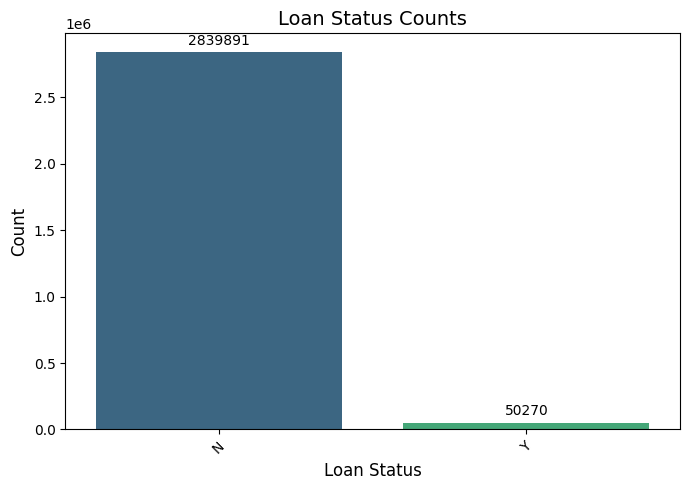

In [7]:
# Calculate value counts for loan_status
loan_status_counts = df['debt_settlement_flag'].value_counts()

# Create the bar plot
plt.figure(figsize=(7, 5))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="viridis")

# Add text annotations for each bar
for i, value in enumerate(loan_status_counts.values):
    plt.text(i, value + 0.02 * max(loan_status_counts.values),  # Adjust text position slightly above the bar
             f'{value}', ha='center', fontsize=10)

# Customize the plot
plt.title("Loan Status Counts", fontsize=14)
plt.xlabel("Loan Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

unbalanced dataset

**3. Unbalanced Data**

In [8]:
# Filter rows where 'debt_settlement_flag' is 'no'
no_flag_rows = df[df['debt_settlement_flag'] == 'N']

# Check if enough rows are available for sampling
if len(no_flag_rows) >= 50270:
    no_flag_rows = no_flag_rows.sample(n=50270, random_state=42)
else:
    print(f"Not enough rows with 'debt_settlement_flag' == 'N'. Using all {len(no_flag_rows)} rows.")
    # Use all available rows
    no_flag_rows = no_flag_rows

# Filter rows where 'debt_settlement_flag' is not 'no'
other_rows = df[df['debt_settlement_flag'] != 'N']

# Combine the sampled 'no' rows with the other rows
df_balanced = pd.concat([no_flag_rows, other_rows], axis=0).reset_index(drop=True)

In [55]:
df_balanced = pd.concat([no_flag_rows, other_rows], axis=0).reset_index(drop=True)
df_balanced

NameError: name 'no_flag_rows' is not defined

In [10]:
df_balanced.to_csv('df_balanced.csv')

**4. LabelEncoder**

In [61]:
import pandas as pd
df_balanced = pd.read_csv('df_balanced.csv')

In [62]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'target' is the dependent variable and the rest are features
X = df_balanced.drop(columns=['debt_settlement_flag'])
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [63]:
df_balanced.drop(columns=[
    'id', 'url', 'title', 'emp_title', 
    'pymnt_plan', 'hardship_flag', 
    'issue_d', 'last_pymnt_d', 'last_credit_pull_d'
], inplace=True)
X = df_balanced.drop(columns=['debt_settlement_flag'])
y = df_balanced['debt_settlement_flag']
y = df_balanced['debt_settlement_flag'].replace({'N': 0, 'Y': 1})
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [64]:
categorical_features

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util',
       'initial_list_status', 'application_type'],
      dtype='object')

In [65]:
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
for col in categorical_features:
    encoder = LabelEncoder()
    X_encoded[col] = encoder.fit_transform(X[col])

X_encoded = X_encoded.iloc[:, 1:] 
print(X_encoded.head())

   loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0    12000.0      12000.0          12000.0     1       269       285.42   
1     6550.0       6550.0           6550.0     0       330       233.50   
2    20000.0      20000.0          20000.0     0        47       622.68   
3    24000.0      24000.0          24000.0     1       329       595.82   
4    12500.0      12500.0          12475.0     0       116       405.76   

   grade  sub_grade  emp_length  home_ownership  ...  num_tl_90g_dpd_24m  \
0      2         14           1               1  ...                 1.0   
1      3         17          10               5  ...                 0.0   
2      0          2           4               1  ...                 0.0   
3      2         13           5               1  ...                 0.0   
4      1          7          10               1  ...                 0.0   

   num_tl_op_past_12m  pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies  \
0          

## Generalized Linear Model (Logistic Regression)

In [66]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

# Add polynomial features
poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(X_encoded)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

In [67]:
# Initialize parameters
n_samples, n_features = X_scaled.shape
beta = np.zeros(n_features)  # Coefficients
max_iter = 100
tol = 1e-6

# Add intercept term
X_scaled = np.hstack((np.ones((n_samples, 1)), X_scaled))
beta = np.zeros(X_scaled.shape[1])

# Logistic function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Ridge

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Logistic Regression with L2 regularization (default)
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
model.fit(X_scaled, y)

# Predictions
y_pred = model.predict(X_scaled)
y_pred_prob = model.predict_proba(X_scaled)[:, 1]

# Evaluation
accuracy = accuracy_score(y, y_pred)
auc_roc = roc_auc_score(y, y_pred_prob)

print("Accuracy:", accuracy)
print("AUC-ROC:", auc_roc)
print("Coefficients:", model.coef_)

Accuracy: 0.9422418937736224
AUC-ROC: 0.9699699363639253
Coefficients: [[-9.00925860e-02 -6.34288015e-01  2.61066473e-01 -5.84451405e-03
  -4.95311429e-02 -5.26062190e-02 -9.13369019e-02 -9.87922840e-02
  -8.73996673e-02 -3.85633796e-02  1.72227817e-02  3.69431926e-03
   1.38497547e-02 -2.16778337e+00 -4.14276091e-02 -2.06646650e-02
   1.55719464e-02  7.89118684e-02 -4.06643525e-02  3.26635200e-03
   1.39093804e-02  1.24748153e-02 -1.33332631e-02  4.27763664e-01
  -3.90557810e-02  5.75627535e-02 -3.24260642e-02 -2.97085813e-02
  -2.08016835e-01 -1.52630585e+00 -1.14859994e+00  3.34426393e-02
  -1.30944129e+00  1.07910497e+00  8.18301130e-01  3.62432058e-01
  -3.57971367e+00  5.70251176e+00 -3.95577284e-01 -8.91737947e-01
   3.78449665e-01 -3.99140031e-02  0.00000000e+00  7.30095283e-02
   2.82347729e-03 -4.34452928e-02  6.58665009e-02 -3.19289444e-02
   2.94539229e-02 -7.19065398e-02  7.10998524e-02  6.09601280e-02
   9.64201563e-04 -6.86776144e-03 -1.27572814e-02  5.36925686e-02
  -5.

### Lasso

In [69]:
# Logistic Regression with L1 regularization (default)
model2 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model2.fit(X_scaled, y)

# Predictions
y_pred2 = model2.predict(X_scaled)
y_pred_prob2 = model2.predict_proba(X_scaled)[:, 1]

# Evaluation
accuracy2 = accuracy_score(y, y_pred2)
auc_roc2 = roc_auc_score(y, y_pred_prob2)

print("Accuracy:", accuracy2)
print("AUC-ROC:", auc_roc2)
print("Coefficients:", model2.coef_)

Accuracy: 0.9422617863536901
AUC-ROC: 0.9699342887971296
Coefficients: [[-3.94786642e-01 -1.17011593e-01  3.38427395e-02 -3.06572075e-01
  -4.57852283e-02 -5.33516701e-02 -7.98620842e-02 -9.72312276e-02
  -8.91294698e-02 -3.84874750e-02  1.68435949e-02  3.58506316e-03
   1.37175287e-02 -2.16667061e+00 -4.09918281e-02 -2.06512098e-02
   1.52883282e-02  7.88166161e-02 -3.96706054e-02  3.13684673e-03
   1.30926340e-01 -1.04746802e-01 -1.22374985e-02  3.46408914e-01
  -3.82140122e-02  4.90864194e-02 -3.15691010e-02  1.05777145e-02
  -2.08031472e-01 -2.25542757e+00 -4.18219666e-01  2.35702055e-02
  -1.34074236e-01  1.74822328e-01  4.41200612e-01  3.60045069e-01
  -4.28534504e+00  6.06498328e+00 -3.92641676e-01 -8.92235185e-01
   3.78551268e-01 -3.98803087e-02  0.00000000e+00  7.24676639e-02
   1.34088090e-03 -4.31507623e-02  5.92261501e-02 -2.36005162e-02
   2.97202186e-02 -6.93160832e-02  6.24092926e-02  5.83134263e-02
   7.01734827e-04 -6.47788552e-03 -1.23491786e-02  5.33113251e-02
  -5.

In [70]:
from sklearn.model_selection import train_test_split, cross_val_predict
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression with L2 regularization (Ridge)
model_ridge = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
model_ridge.fit(X_train, y_train)

# Predictions for Ridge
y_pred_ridge_train = model_ridge.predict(X_train)
y_pred_ridge_test = model_ridge.predict(X_test)
y_pred_ridge_prob_train = model_ridge.predict_proba(X_train)[:, 1]
y_pred_ridge_prob_test = model_ridge.predict_proba(X_test)[:, 1]

# Logistic Regression with L1 regularization (Lasso)
model_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_lasso.fit(X_train, y_train)

# Predictions for Lasso
y_pred_lasso_train = model_lasso.predict(X_train)
y_pred_lasso_test = model_lasso.predict(X_test)
y_pred_lasso_prob_train = model_lasso.predict_proba(X_train)[:, 1]
y_pred_lasso_prob_test = model_lasso.predict_proba(X_test)[:, 1]

# Metrics Calculation
results = []

for name, model, y_train_prob, y_test_prob, y_train_pred, y_test_pred in [
    ("Ridge", model_ridge, y_pred_ridge_prob_train, y_pred_ridge_prob_test, y_pred_ridge_train, y_pred_ridge_test),
    ("Lasso", model_lasso, y_pred_lasso_prob_train, y_pred_lasso_prob_test, y_pred_lasso_train, y_pred_lasso_test),
]:
    # In-sample and Out-of-sample MSPE
    in_sample_mspe = mean_squared_error(y_train, y_train_prob)
    out_sample_mspe = mean_squared_error(y_test, y_test_prob)

    # Nonzero coefficients
    nonzero_coefficients = np.sum(model.coef_ != 0)

    # % of predictions outside [0, 1]
    outside_range_percentage = np.mean((y_test_prob < 0) | (y_test_prob > 1)) * 100

    results.append({
        "Model": name,
        "In-sample MSPE": in_sample_mspe,
        "Out-of-sample MSPE": out_sample_mspe,
        "No. nonzero coefficients": nonzero_coefficients,
        "% of ŷ ∉ [0, 1]": outside_range_percentage,
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

   Model  In-sample MSPE  Out-of-sample MSPE  No. nonzero coefficients  \
0  Ridge        0.049827            0.050612                        81   
1  Lasso        0.049784            0.050546                        81   

   % of ŷ ∉ [0, 1]  
0              0.0  
1              0.0  


## Results
Compare Ridge and Lasso

In [71]:
results_df

,Model,In-sample MSPE,Out-of-sample MSPE,No. nonzero coefficients,"% of ŷ ∉ [0, 1]"
0,Ridge,0.049827,0.050612,81,0.0
1,Lasso,0.049784,0.050546,81,0.0


In [72]:
from sklearn.metrics import log_loss
logloss1 = log_loss(y, y_pred_prob)
print(f"Log Loss (L2 Regularization): {logloss1:.10f}")
logloss2 = log_loss(y, y_pred_prob2)
print(f"Log Loss (L1 Regularization): {logloss2:.10f}")

Log Loss (L2 Regularization): 0.1970277313
Log Loss (L1 Regularization): 0.1970333911


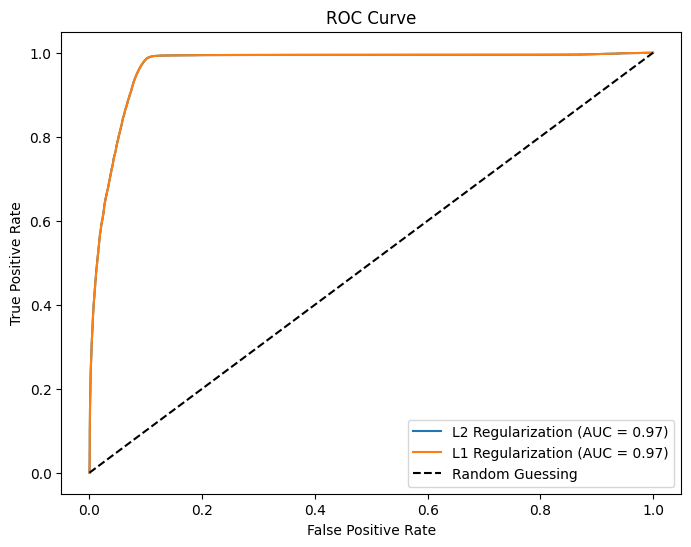

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 模型 1: L2 正则化
fpr1, tpr1, _ = roc_curve(y, y_pred_prob)
auc1 = roc_auc_score(y, y_pred_prob)

# 模型 2: L1 正则化
fpr2, tpr2, _ = roc_curve(y, y_pred_prob2)
auc2 = roc_auc_score(y, y_pred_prob2)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f"L2 Regularization (AUC = {auc1:.2f})")
plt.plot(fpr2, tpr2, label=f"L1 Regularization (AUC = {auc2:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


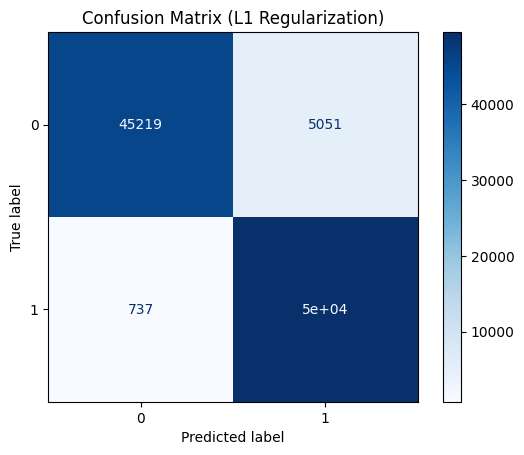

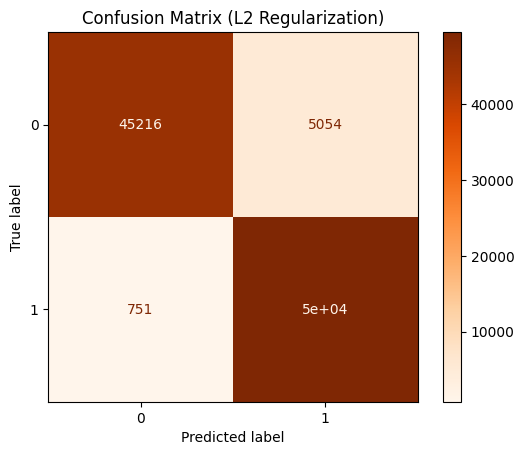

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm1 = confusion_matrix(y, model.predict(X_scaled))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=model.classes_)
disp1.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (L1 Regularization)")
plt.show()

cm2 = confusion_matrix(y, model2.predict(X_scaled))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model2.classes_)
disp2.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix (L2 Regularization)")
plt.show()

In [94]:
# Preserve feature names from the original DataFrame
feature_names = X.columns  # Use the original DataFrame before splitting or scaling

# Assuming `feature_names` is a list of the original column names
ridge_coefficients = model_ridge.coef_[0]
lasso_coefficients = model_lasso.coef_[0]

# Get top indices for Ridge and Lasso
ridge_top_indices = np.argsort(-np.abs(ridge_coefficients))[:10]  # Top 10 features by Ridge
lasso_top_indices = np.argsort(-np.abs(lasso_coefficients))[:10]  # Top 10 features by Lasso

# Display top features by name and their coefficient values
print("Top Features by Ridge Regression:")
for idx in ridge_top_indices:
    print(f"{feature_names[idx]}: {ridge_coefficients[idx]}")

print("\nTop Features by Lasso Regression:")
for idx in lasso_top_indices:
    print(f"{feature_names[idx]}: {lasso_coefficients[idx]}")


Top Features by Ridge Regression:
collection_recovery_fee: 5.787029748687884
recoveries: -3.637729178428151
loan_status: -2.1522872469080103
out_prncp: -1.4338396283171857
total_pymnt_inv: -1.3329698740422575
out_prncp_inv: -1.2080247139751887
total_rec_prncp: 1.0907840408611749
last_fico_range_high: -0.8903124635100467
total_rec_int: 0.8223426589626727
loan_amnt: -0.5623576739757876

Top Features by Lasso Regression:
collection_recovery_fee: 6.404632224414897
recoveries: -4.5063389858924525
loan_status: -2.151866957113577
out_prncp: -1.7460661124848993
out_prncp_inv: -0.8964110483139082
last_fico_range_high: -0.8902585651008835
total_rec_int: 0.5428015242844475
Unnamed: 0: -0.5186518151669322
total_pymnt_inv: -0.49996010062590723
total_rec_prncp: 0.42155964739924484
